In [1]:
%pylab inline
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform
from jax.scipy.ndimage import map_coordinates
from constant import * 
import warnings
from jax import jit
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
cgrid = np.load("cgrid.npy")
bgrid = np.load("bgrid.npy")
kgrid = np.load("kgrid.npy")
hgrid = np.load("hgrid.npy")

In [3]:
# define approximation of fit
def actions(w, s, t):
    c = map_coordinates(cgrid[:,:,t],np.vstack((w,s)), order = 1, mode = 'nearest')
    b = map_coordinates(bgrid[:,:,t],np.vstack((w,s)), order = 1, mode = 'nearest')
    k = map_coordinates(kgrid[:,:,t],np.vstack((w,s)), order = 1, mode = 'nearest')
    h = map_coordinates(hgrid[:,:,t],np.vstack((w,s)), order = 1, mode = 'nearest')
    return c,b,k,h
      
@jit    
def transition(b,k,s,s_next):
    return b*(1+r_b[s]) + k*(1+r_k[s_next])

In [4]:
import quantecon as qe
#number of economy
num = 500000
# markov chain used to generate economic states
mc = qe.MarkovChain(Ps)
econState = np.array([mc.simulate(ts_length=T_max - T_min, init=0) for _ in range(num)])

In [5]:
#initially with 5k wealth
w = np.ones(num)*5
ws = np.zeros((T_max-T_min,num))
cs = np.zeros((T_max-T_min,num))
bs = np.zeros((T_max-T_min,num))
ks = np.zeros((T_max-T_min,num))
hs = np.zeros((T_max-T_min,num))
for t in range(T_max-T_min-1):
    s = econState[:,t]
    c,b,k,h = actions(w, s, t)
    ws[t,:] = w
    cs[t,:] = c
    bs[t,:] = b
    ks[t,:] = k
    hs[t,:] = h
    w = transition(b,k,econState[:,t],econState[:,t+1])

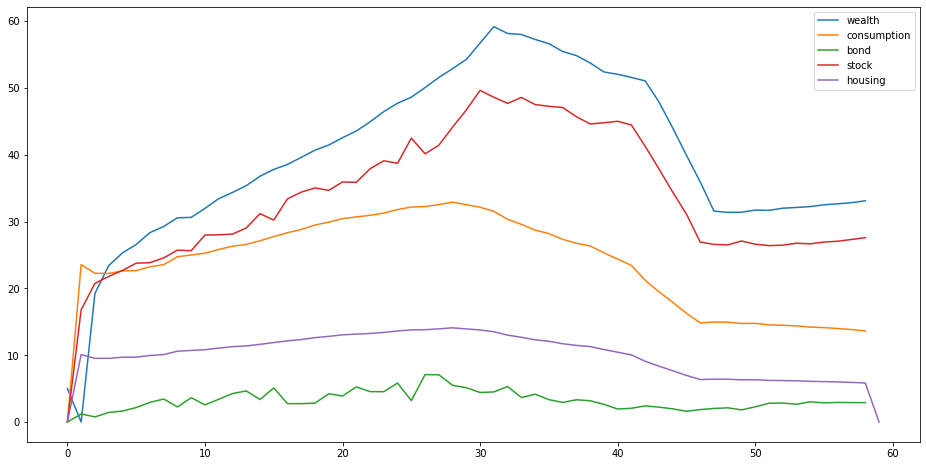

In [6]:
plt.figure(figsize = [16,8])
plt.plot(ws.mean(axis = 1)[:-1], label = "wealth")
plt.plot(cs.mean(axis = 1)[:-1], label = "consumption")
plt.plot(bs.mean(axis = 1)[:-1], label = "bond")
plt.plot(ks.mean(axis = 1)[:-1], label = "stock")
plt.plot((hs*pr).mean(axis = 1), label = "housing")
plt.legend()